In [39]:
import os
import cv2
import json
import base64
import skimage.draw
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('trainval.json', 'r') as op:
    json_data = json.load(op)

In [3]:
json_data['categories']

[{'supercategory': 'Damage', 'id': 0, 'name': 'Damage'},
 {'supercategory': 'Dent', 'id': 1, 'name': 'Dent'},
 {'supercategory': 'Scratch', 'id': 2, 'name': 'Scratch'}]

In [18]:
len(json_data['annotations'])

702

In [4]:
json_data['annotations'][0]

{'segmentation': [[129.67326732673268,
   203.26732673267333,
   139.5742574257426,
   153.76237623762378,
   147.49504950495052,
   128.01980198019805,
   152.44554455445547,
   105.24752475247527,
   176.20792079207922,
   94.3564356435644,
   194.02970297029705,
   99.30693069306935,
   211.85148514851488,
   105.24752475247527,
   228.6831683168317,
   107.22772277227725,
   239.5742574257426,
   106.23762376237627,
   262.34653465346526,
   103.2673267326733,
   278.18811881188117,
   98.31683168316835,
   293.039603960396,
   86.43564356435647,
   303.9306930693068,
   77.52475247524757,
   321.75247524752467,
   75.54455445544556,
   339.57425742574253,
   68.61386138613864,
   363.33663366336623,
   67.62376237623766,
   378.18811881188117,
   71.58415841584161,
   410.86138613861385,
   75.54455445544556,
   437.5940594059406,
   78.51485148514854,
   459.37623762376234,
   85.44554455445547,
   493.039603960396,
   95.34653465346537,
   547.4950495049504,
   105.2475247524752

In [100]:
ann = json_data['annotations'][0]['segmentation'][0]

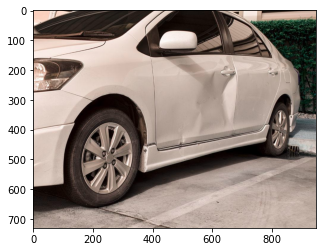

In [102]:
img = cv2.imread('trainimages/0.jpg')
shape = img.shape[:2]
plt.imshow(img)

In [103]:
mask = np.zeros(shape)

In [107]:
shape

(730, 950)

In [105]:
temp_annotations=[]
for i in range(0, len(ann), 2):
    temp_annotations.append([ann[i], ann[i+1]])
temp_annotations = np.array(temp_annotations)
temp_annotations = temp_annotations.squeeze()
polygon = skimage.draw.polygon(temp_annotations[:,0], temp_annotations[:,1], shape)

# create the actual mask
mask[polygon[0], polygon[1]] = 1

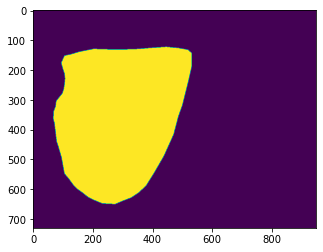

In [106]:
plt.imshow(mask)

In [6]:
def damage_type_to_class(damage_category):
    # damage
    if damage_category == 0:
        return 3
    # dent
    elif damage_category == 1:
        return 2
    # scratch
    else:
        return 2

In [113]:
def add_annotations_to_mask(annotations, mask, damage_class):
    # store the annotation in [x,y] format in this list
    temp_annotations = []
    
    # convert the annotations in list formamt [x,y,x,y,x,....] to grouped format [x, y]
    for i in range(0, len(annotations), 2):
        if annotations[i] < mask.shape[0] and annotations[i+1] < mask.shape[1]:
            temp_annotations.append([annotations[i], annotations[i+1]])
    temp_annotations = np.array(temp_annotations)
    temp_annotations = temp_annotations.squeeze()
    polygon = skimage.draw.polygon(temp_annotations[:,0], temp_annotations[:,1], shape)

    # create the actual mask
    mask[polygon[0], polygon[1]] = damage_class
    
    return mask

In [114]:
def generate_masks(json_path, image_path, mask_dest):
    # read the json present in the jsono_path
    with open('trainval.json', 'r') as op:
        json_data = json.load(op)
    
    # mask storing dictionary which stores 1 mask per image
    mask_list = {}
    
    print('Processing {} annotations'.format(len(json_data['annotations'])))
    # generate masks based on each annotation polygon provided in the json
    done_ann = 0
    for ann in json_data['annotations']:
        # get the damage category of the mask
        damage_category = damage_type_to_class(ann['category_id'])
        
        # get the corresponding image and its shape for this mask
        image_id = ann['image_id']
        img = cv2.imread(os.path.join(image_path, str(image_id)+'.jpg'))
        image_shape = img.shape[:2]
        
        if image_id not in mask_list:
            mask = np.zeros(image_shape)
        else:
            mask = mask_list.get(image_id)
        
        # convert the annotations points into a binary mask
        mask = add_annotations_to_mask(ann['segmentation'][0], mask, damage_category)
        mask_list[image_id] = mask
        
        done_ann += 1
        if done_ann % 50 == 0:
            print('Completed processing {} annotations'.format(done_ann))
    print('Finished processing Annotations')
    
    # store the mask in a folder in numpy array format
    print('Saving {} mask as numpy array'.format(len(mask_list.keys())))
    done_mask = 0
    for image_id, mask in mask_list:
        mask_path = os.path.join(mask_dest, image_id)
        np.save(mask_path, mask)
        
        done_mask += 1
        if done_mask % 50 == 0:
            print('completed saving {} masks'.format(done_mask))
    
    print('Finished saving masks as numpy array')

In [115]:
json_path = 'trainval.json'
image_path = 'trainimages'
mask_dest = 'pixel_wise_masks'

In [116]:
!rm -rf {mask_dest}
!mkdir {mask_dest}

In [117]:
generate_masks(json_path, image_path, mask_dest)

Processing 702 annotations


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed